In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from dictys.net import dynamic_network

#### Utils ####

In [2]:
def load_data(data_file):
    """
    Load the dynamic network data as dictys object and define trajectory branches.
    """
    d0 = dynamic_network.from_file(data_file)
    return d0

def get_tf_indices(dictys_dynamic_object, tf_list):
    """
    Get the indices of transcription factors from a list, if present in ndict and nids[0].
    """
    gene_hashmap = dictys_dynamic_object.ndict
    tf_mappings_to_gene_hashmap = dictys_dynamic_object.nids[0] 
    tf_indices = []  
    gene_indices = []  
    for gene in tf_list:
        # Check if the gene is in the gene_hashmap
        if gene in gene_hashmap:
            gene_index = gene_hashmap[gene]  # Get the index in gene_hashmap
            # Check if the gene index is present in tf_mappings_to_gene_hashmap
            match = np.where(tf_mappings_to_gene_hashmap == gene_index)[0]
            if match.size > 0:  # If a match is found
                tf_indices.append(int(match[0]))  # Append the position of the match
                gene_indices.append(int(gene_index))  # Also append the gene index 
    return tf_indices, gene_indices

def get_pseudotime_of_windows(dictys_dynamic_object, window_indices):
    """
    Get the pseudotime of specific windows for x-axis in plots
    """
    pseudotime_relative_to_bifurcation = dictys_dynamic_object.point['s'].locs  # Access via dictionary keys
    branch_pseudotime = [float(pseudotime_relative_to_bifurcation[idx]) for idx in window_indices]
    return branch_pseudotime

def get_weights_across_windows(dictys_dynamic_object, tf_indices, window_indices):
    """
    Get the non-zero weights of TFs over specific windows for x-axis in plots
    """
    # Access the 3-D array of weights from prop['es']['w_n'] and slice it using np.ix_
    weights_of_tf_target = dictys_dynamic_object.prop['es']['w_n'][np.ix_(tf_indices, range(15767), window_indices)]
    return weights_of_tf_target

def get_indirect_weights_across_windows(dictys_dynamic_object, tf_indices, window_indices):
    """
    Get the indirect weights of TFs over specific windows for x-axis in plots
    """
    indirect_weights_of_tf_target = dictys_dynamic_object.prop['es']['w_in'][np.ix_(tf_indices, range(15767), window_indices)]
    return indirect_weights_of_tf_target

#### Plotting code ####

In [37]:
import matplotlib.colors as colors

def plot_log_cpm_tfs(dictys_dynamic_object, gene_indices, window_indices, tf_list, branch_name):
    """
    Plot the log CPM of transcription factors (TFs) as a function of pseudo-time and display the plot in the notebook.
    """
    cpm_values = dictys_dynamic_object.prop['ns']['cpm'][np.ix_(gene_indices, window_indices)]
    log_cpm_values = np.log(cpm_values)
    branch_pseudotime = get_pseudotime_of_windows(dictys_dynamic_object, window_indices)
    plt.figure(figsize=(10, 6))
    for i, tf_name in enumerate(tf_list):
        plt.plot(branch_pseudotime, log_cpm_values[i, :], label=tf_name)  # i corresponds to each TF
    plt.xlabel('Pseudotime')
    plt.ylabel('log(CPM) of TFs')
    plt.title(f'log(CPM) of TFs for {branch_name} Branch')
    plt.legend(title='Transcription Factors')
    plt.show()  # Display the plot in the notebook

def plot_node_degree(dictys_dynamic_object, non_zero_weights_per_tf, window_indices, tf_list, branch_name):
    """
    Plot the node degree of TFs as a function of pseudo-time.
    """
    branch_pseudotime = get_pseudotime_of_windows(dictys_dynamic_object, window_indices)
    plt.figure(figsize=(10, 6))
    for i, tf_name in enumerate(tf_list):
        plt.plot(branch_pseudotime, non_zero_weights_per_tf[i, :], label=tf_name)  # i corresponds to each TF
    plt.xlabel('Pseudotime')
    plt.ylabel('Node Degree of TFs')
    plt.title(f'Node Degree of TFs for {branch_name} Branch')
    plt.legend(title='Transcription Factors')
    plt.show()  # Display the plot in the notebook

def plot_regulation_heatmap(weights, tf_list, branch_name, global_vmin, global_vmax):
    """
    Plot the regulation heatmap of TFs as a function of pseudo-time.
    """
    n_tfs, n_targets, n_windows = weights.shape
    weights_reshaped = weights.reshape(n_tfs * n_targets, n_windows)
    tf_target_labels = [f"{tf}-{tf_list[i]}" for tf in tf_list for i in range(n_targets)]
    # Remove self-regulation rows
    non_self_reg_indices = [i for i in range(len(tf_target_labels)) if tf_target_labels[i].split('-')[0] != tf_target_labels[i].split('-')[1]]
    weights_reshaped = weights_reshaped[non_self_reg_indices]
    tf_target_labels = [tf_target_labels[i] for i in non_self_reg_indices]
    # Create a custom colormap
    colors_list = ['red', 'white', 'blue']
    n_bins = 100  # Number of bins in the colormap
    cmap = colors.LinearSegmentedColormap.from_list('custom', colors_list, N=n_bins)
    plt.figure(figsize=(12, 10))
    im = plt.imshow(weights_reshaped, aspect='auto', cmap=cmap, interpolation='nearest', vmin=global_vmin, vmax=global_vmax)
    plt.colorbar(im, label='Regulation strength')
    plt.xlabel('Pseudotime')
    plt.ylabel('TF-Target pairs')
    plt.title(f'Dynamic regulation strength - {branch_name} branch')
    plt.yticks(range(len(tf_target_labels)), tf_target_labels)
    plt.tight_layout()
    plt.show()


## Execute the analysis

In [19]:
# Define file paths 
data_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/output/dynamic.h5'
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/output'
# Define the transcription factors
tf_list = ['IRF4', 'IRF8', 'PRDM1', 'BCL6']

In [6]:
# Load data
dictys_dynamic_object = load_data(data_file)

In [20]:
# Get the TF indices
tf_indices, gene_indices = get_tf_indices(dictys_dynamic_object, tf_list)
print(f"TF indices: {tf_indices}")
print(f"Gene indices: {gene_indices}")

TF indices: [126, 129, 219, 15]
Gene indices: [6126, 6130, 10330, 1224]


In [21]:
# Assign window indices for each branch between 0 to 92
pb_window_indices = list(range(4, 19)) + [1]
abc_window_indices = [0] + list(range(19, 67)) + [2]
gc_window_indices = list(range(67, 93)) + [3]


In [22]:
# get normalized weights
weights_of_tf_target_pb = get_weights_across_windows(dictys_dynamic_object, tf_indices, pb_window_indices)
weights_of_tf_target_abc = get_weights_across_windows(dictys_dynamic_object, tf_indices, abc_window_indices)
weights_of_tf_target_gc = get_weights_across_windows(dictys_dynamic_object, tf_indices, gc_window_indices)
print(weights_of_tf_target_pb.shape)
print(weights_of_tf_target_abc.shape)
print(weights_of_tf_target_gc.shape)


(4, 15767, 16)
(4, 15767, 50)
(4, 15767, 27)


In [24]:
# get non-zero weights per tf (node-degree)
non_zero_weights_per_tf_pb = np.count_nonzero(weights_of_tf_target_pb, axis=1)
non_zero_weights_per_tf_abc = np.count_nonzero(weights_of_tf_target_abc, axis=1)
non_zero_weights_per_tf_gc = np.count_nonzero(weights_of_tf_target_gc, axis=1)

# # plot node degree
# plot_node_degree(dictys_dynamic_object, non_zero_weights_per_tf_pb, pb_window_indices, tf_list, 'PB')
# plot_node_degree(dictys_dynamic_object, non_zero_weights_per_tf_abc, abc_window_indices, tf_list, 'ABC')
# plot_node_degree(dictys_dynamic_object, non_zero_weights_per_tf_gc, gc_window_indices, tf_list, 'GC')


In [25]:
# subset the weight matrix to only inclue the gene_indices queried 6126, 6130, 10330, 1224 
weights_of_tf_target_pb_subset = weights_of_tf_target_pb[:, [6126, 6130, 10330, 1224], :]
weights_of_tf_target_abc_subset = weights_of_tf_target_abc[:, [6126, 6130, 10330, 1224], :]
weights_of_tf_target_gc_subset = weights_of_tf_target_gc[:, [6126, 6130, 10330, 1224], :]

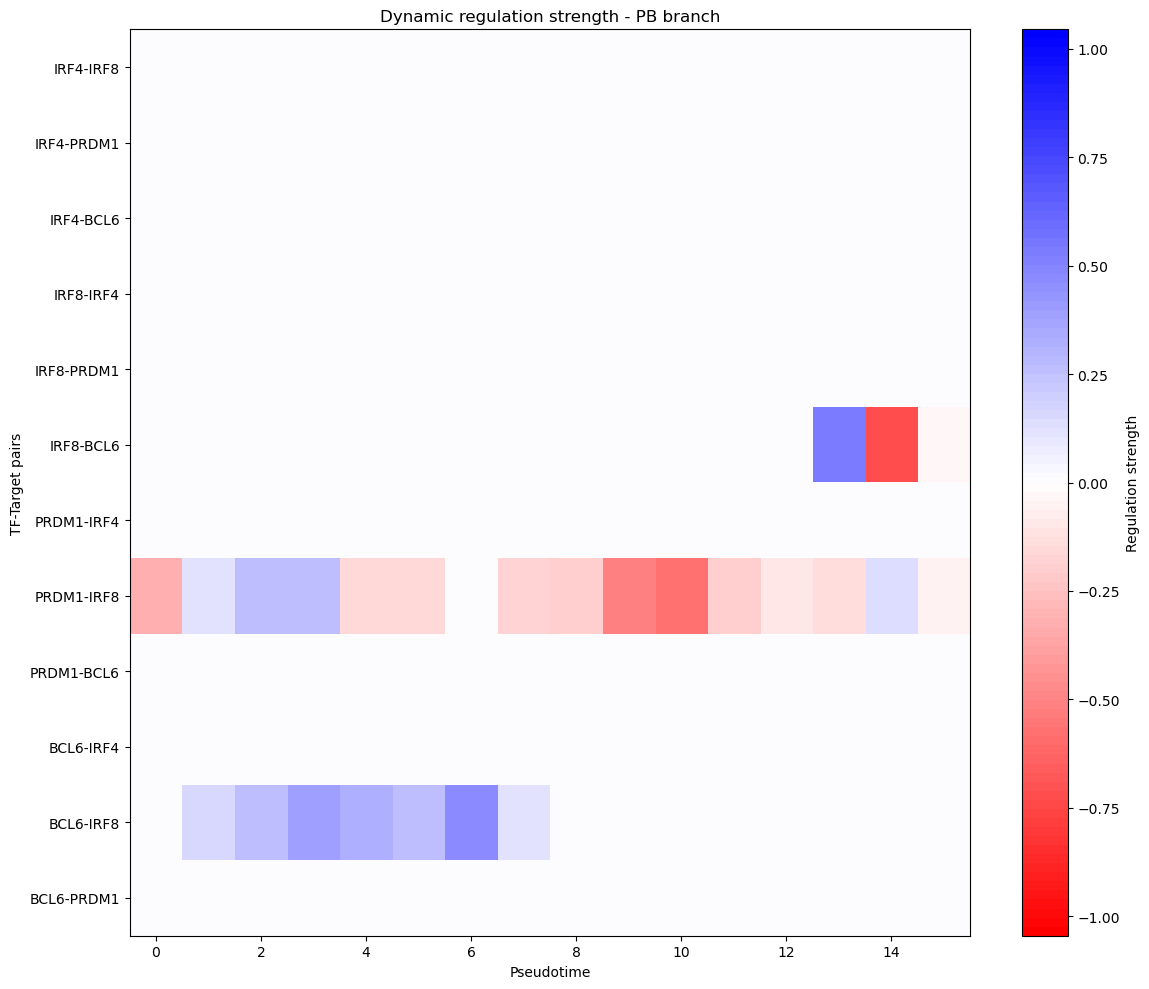

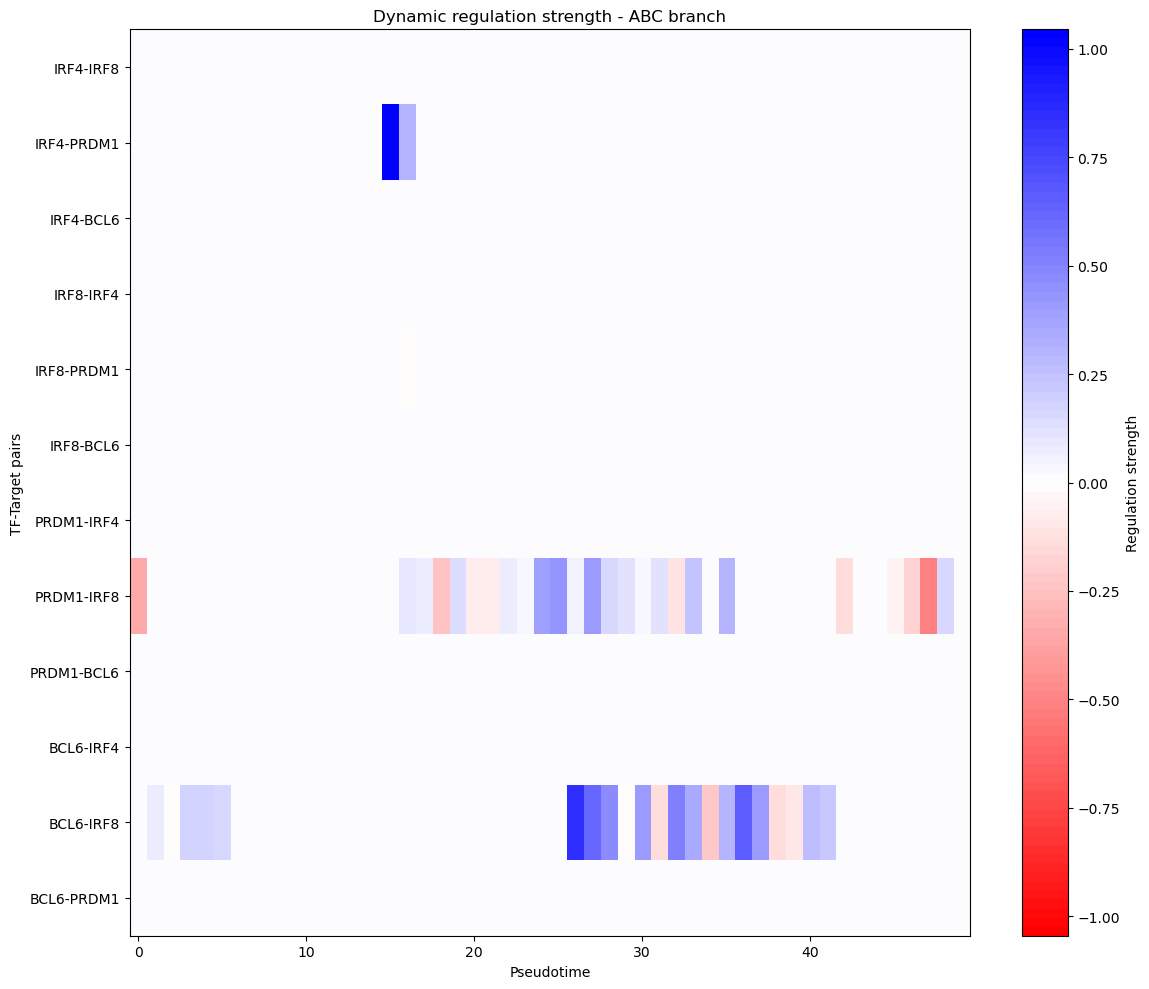

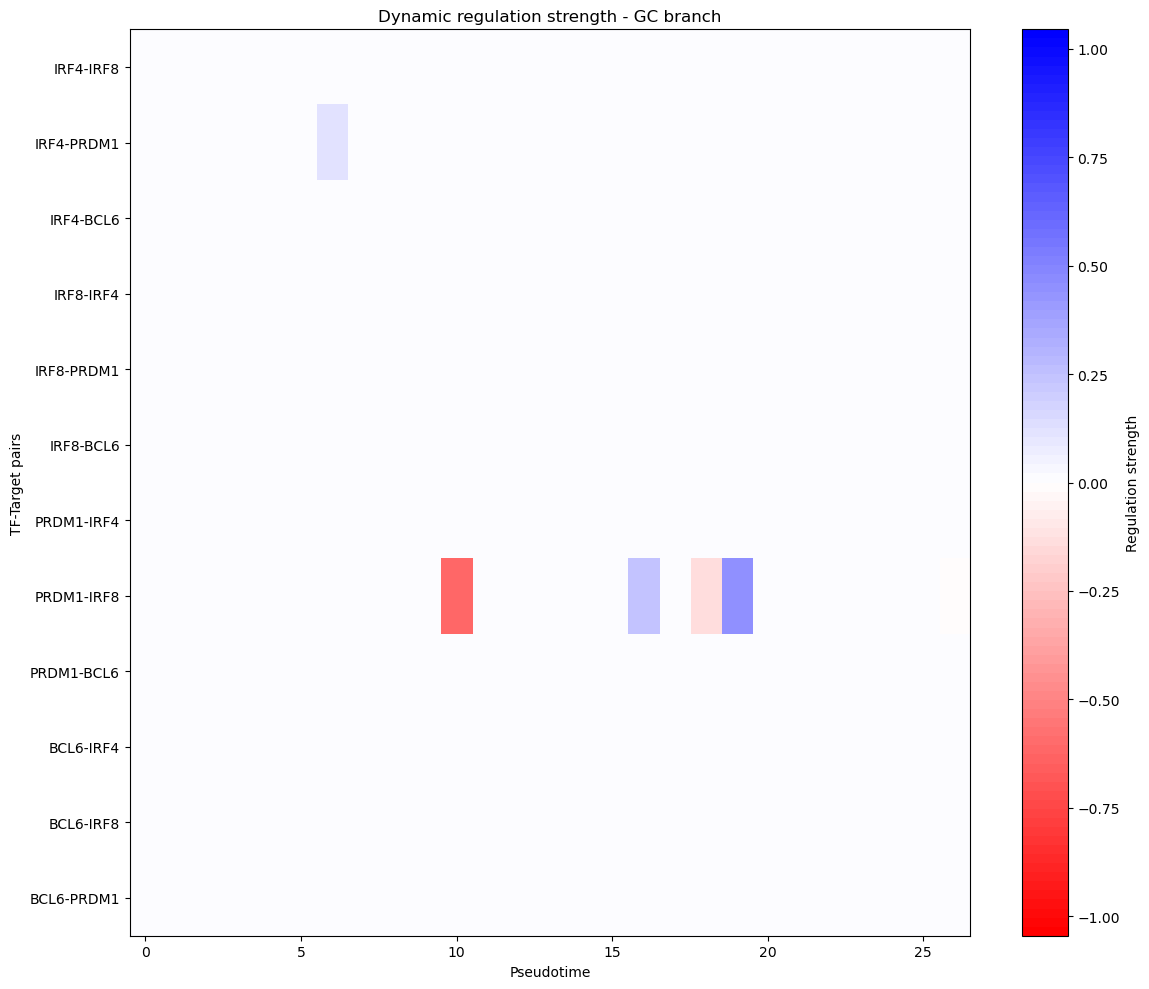

In [39]:
# Calculate global min and max across all branches
all_weights = np.concatenate([
    weights_of_tf_target_pb_subset.flatten(),
    weights_of_tf_target_abc_subset.flatten(),
    weights_of_tf_target_gc_subset.flatten()
])
global_vmin = np.min(all_weights)
global_vmax = np.max(all_weights)
global_vmax = max(abs(global_vmin), abs(global_vmax))
global_vmin = -global_vmax

# plot heatmap of weights per branch
plot_regulation_heatmap(weights_of_tf_target_pb_subset, tf_list, 'PB', global_vmin, global_vmax)
plot_regulation_heatmap(weights_of_tf_target_abc_subset, tf_list, 'ABC', global_vmin, global_vmax)
plot_regulation_heatmap(weights_of_tf_target_gc_subset, tf_list, 'GC', global_vmin, global_vmax)
